In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-04-26 16:34:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-26 16:34:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-26 16:34:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [10]:
from google.colab import files
uploaded = files.upload()


Saving conllpp_dev.txt to conllpp_dev.txt


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 555.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [59]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, TimeDistributed, Dense , Conv1D, MaxPooling1D ,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score,classification_report

In [6]:
def load_data(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    sentences, labels = [], []
    sentence, label = [], []

    for line in lines:
        if line == "\n" or line.startswith("-DOCSTART-"):
            if sentence and label:
                sentences.append(sentence)
                labels.append(label)
                sentence, label = [], []
        else:
            word, _, _, tag = line.strip().split()
            sentence.append(word.lower())  # Normalize the case
            label.append(tag)

    return sentences, labels

In [60]:


train_file_path = "conllpp_train.txt"
test_file_path = "conllpp_test.txt"

train_sentences, train_labels = load_data(train_file_path)
test_sentences, test_labels = load_data(test_file_path)



In [12]:
import pandas as pd

df = pd.DataFrame({
    "train_sentences":train_sentences,
    "train_labels":train_labels
})
df

,train_sentences,train_labels
0,"[eu, rejects, german, call, to, boycott, briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,"[peter, blackburn]","[B-PER, I-PER]"
2,"[brussels, 1996-08-22]","[B-LOC, O]"
3,"[the, european, commission, said, on, thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,"[germany, 's, representative, to, the, europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."
...,...,...
14036,"[on, friday, :]","[O, O, O]"
14037,"[division, two]","[O, O]"
14038,"[plymouth, 2, preston, 1]","[B-ORG, O, B-ORG, O]"
14039,"[division, three]","[O, O]"


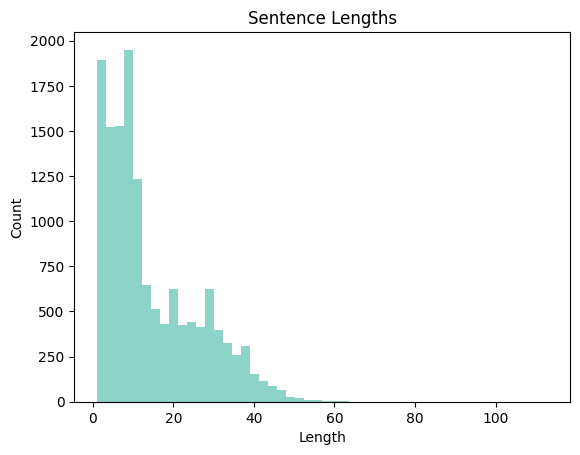

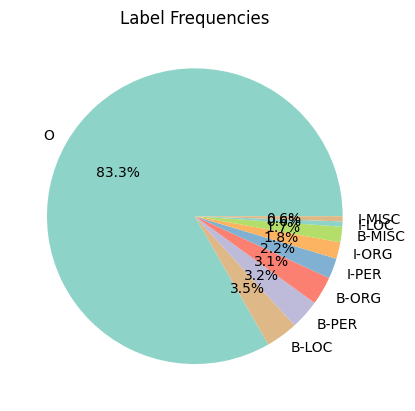

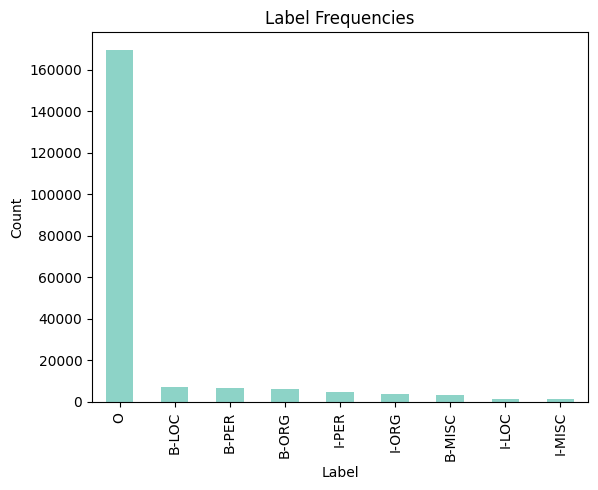

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a histogram of the sentence lengths
sentence_lengths = [len(sentence) for sentence in df['train_sentences']]
plt.hist(sentence_lengths, bins=50, color ='#8dd3c7' )
plt.title('Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# Plot a pie chart of the label frequencies
label_counts = df['train_labels'].explode().value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors= ['#8dd3c7', 'burlywood', '#bebada', '#fb8072',
           '#80b1d3', '#fdb462', '#b3de69'])
plt.title('Label Frequencies')
plt.show()

# Plot a bar chart of the label frequencies
label_counts.plot(kind='bar', color = '#8dd3c7' )
plt.title('Label Frequencies')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [14]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [16]:
# Create word-to-index and tag-to-index dictionaries
words = list(set([word for sentence in train_sentences + test_sentences for word in sentence]))
words.append('ENDPAD')
n_words = len(words)
tags = list(set([tag for label in train_labels + test_labels for tag in label]))
n_tags = len(tags)

word_index = {w: i for i, w in enumerate(words)}
label_index = {t: i for i, t in enumerate(tags)}

# Convert words and tags to sequences of indices
X_train = [[word_index[w] for w in sentence] for sentence in train_sentences]
X_train = pad_sequences(maxlen=50, sequences=X_train, padding='post', value=n_words-1)
y_train = [[label_index[t] for t in label] for label in train_labels]
y_train = pad_sequences(maxlen=50, sequences=y_train, padding='post', value=label_index['O'])
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

X_test = [[word_index[w] for w in sentence] for sentence in test_sentences]
X_test = pad_sequences(maxlen=50, sequences=X_test, padding='post', value=n_words-1)
y_test = [[label_index[t] for t in label] for label in test_labels]
y_test = pad_sequences(maxlen=50, sequences=y_test, padding='post', value=label_index['O'])
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

max_len  = 50

In [17]:


# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [18]:


# Define model architecture
input_layer = Input(shape=(50,))
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
dropout_layer = Dropout(0.5)(embedding_layer)
bidirectional_layer = Bidirectional(LSTM(128, return_sequences=True))(dropout_layer)
output_layer = TimeDistributed(Dense(len(label_index), activation='softmax'))(bidirectional_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, np.array(y_train), validation_split=0.1, batch_size=32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.9820 - loss: 0.0614 - val_accuracy: 0.9841 - val_loss: 0.0533
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9843 - loss: 0.0533 - val_accuracy: 0.9860 - val_loss: 0.0490
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9858 - loss: 0.0481 - val_accuracy: 0.9860 - val_loss: 0.0469
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9867 - loss: 0.0444 - val_accuracy: 0.9869 - val_loss: 0.0458
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 138ms/step - accuracy: 0.9871 - loss: 0.0427 - val_accuracy: 0.9872 - val_loss: 0.0432
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9882 - loss: 0.0388 - val_accuracy: 0.9876 - val_loss: 0.0443
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9883 - loss: 0.0382 - val_accuracy: 0.9880 - val_loss: 0.0406
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 138ms/step - accuracy: 0.9896 - loss: 0

In [22]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Aplatir les étiquettes de test (y_test) et les prédictions (y_pred)
y_test_labels = [[tags[i] for i in row] for row in np.argmax(y_test, axis=-1)]
y_pred_labels = [[tags[i] for i in row] for row in y_pred]

# Aplatir les listes pour le classification_report
y_test_labels_flat = [label for sublist in y_test_labels for label in sublist]
y_pred_labels_flat = [label for sublist in y_pred_labels for label in sublist]

# Print classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print(report)




108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
              precision    recall  f1-score   support

       B-LOC       0.88      0.91      0.90      1630
      B-MISC       0.88      0.67      0.76       721
       B-ORG       0.87      0.79      0.83      1708
       B-PER       0.96      0.93      0.94      1579
       I-LOC       0.76      0.76      0.76       258
      I-MISC       0.85      0.52      0.64       252
       I-ORG       0.87      0.64      0.74       880
       I-PER       0.97      0.96      0.96      1119
           O       0.99      1.00      1.00    164453

    accuracy                           0.99    172600
   macro avg       0.89      0.80      0.84    172600
weighted avg       0.99      0.99      0.99    172600



In [65]:
# Modèle avec CNN + LSTM
input_layer = Input(shape=(50,))
embedding_layer = Embedding(len(word_index)+1, embedding_dim, weights=[embedding_matrix],
                          input_length=50, trainable=False)(input_layer)

# Conv1D avec padding pour conserver la longueur
conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(embedding_layer)

# LSTM bidirectionnelle
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(conv_layer)

# Couche de sortie
output_layer = TimeDistributed(Dense(len(label_index), activation='softmax'))(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, np.array(y_train), validation_split=0.1, batch_size=32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 140ms/step - accuracy: 0.9459 - loss: 0.3239 - val_accuracy: 0.9788 - val_loss: 0.0725
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.9850 - loss: 0.0515 - val_accuracy: 0.9834 - val_loss: 0.0581
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9888 - loss: 0.0375 - val_accuracy: 0.9849 - val_loss: 0.0502
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9906 - loss: 0.0317 - val_accuracy: 0.9864 - val_loss: 0.0470
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9921 - loss: 0.0267 - val_accuracy: 0.9877 - val_loss: 0.0427
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9931 - loss: 0.0234 - val_accuracy: 0.9877 - val_loss: 0.0427
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9937 - loss: 0.0211 - val_accuracy: 0.9878 - val_loss: 0.0426
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9948 - loss: 0

In [67]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Aplatir les étiquettes de test (y_test) et les prédictions (y_pred)
y_test_labels = [[tags[i] for i in row] for row in np.argmax(y_test, axis=-1)]
y_pred_labels = [[tags[i] for i in row] for row in y_pred]

# Aplatir les listes pour le classification_report
y_test_labels_flat = [label for sublist in y_test_labels for label in sublist]
y_pred_labels_flat = [label for sublist in y_pred_labels for label in sublist]

# Print classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print(report)

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
              precision    recall  f1-score   support

       B-LOC       0.87      0.92      0.90      1630
      B-MISC       0.82      0.74      0.78       721
       B-ORG       0.89      0.77      0.83      1708
       B-PER       0.94      0.92      0.93      1579
       I-LOC       0.77      0.78      0.77       258
      I-MISC       0.60      0.56      0.58       252
       I-ORG       0.85      0.66      0.74       880
       I-PER       0.95      0.95      0.95      1119
           O       1.00      1.00      1.00    164453

    accuracy                           0.99    172600
   macro avg       0.85      0.81      0.83    172600
weighted avg       0.99      0.99      0.99    172600



In [47]:
# Modèle avec GRU et Dropout
input_layer = Input(shape=(50,))
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# GRU layer
gru_layer = GRU(128, return_sequences=True)(embedding_layer)

# Dropout layer for regularization
dropout_layer = Dropout(0.5)(gru_layer)

# Output layer
output_layer = TimeDistributed(Dense(len(label_index), activation='softmax'))(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, np.array(y_train), validation_split=0.1, batch_size=32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.9367 - loss: 0.4651 - val_accuracy: 0.9739 - val_loss: 0.0974
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9769 - loss: 0.0860 - val_accuracy: 0.9795 - val_loss: 0.0772
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9812 - loss: 0.0690 - val_accuracy: 0.9816 - val_loss: 0.0678
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9838 - loss: 0.0593 - val_accuracy: 0.9828 - val_loss: 0.0615
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9847 - loss: 0.0537 - val_accuracy: 0.9841 - val_loss: 0.0573
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9860 - loss: 0.0490 - val_accuracy: 0.9847 - val_loss: 0.0551
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9866 - loss: 0.0461 - val_accuracy: 0.9851 - val_loss: 0.0538
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9876 - loss: 0.0425 - 

In [68]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Aplatir les étiquettes de test (y_test) et les prédictions (y_pred)
y_test_labels = [[tags[i] for i in row] for row in np.argmax(y_test, axis=-1)]
y_pred_labels = [[tags[i] for i in row] for row in y_pred]

# Aplatir les listes pour le classification_report
y_test_labels_flat = [label for sublist in y_test_labels for label in sublist]
y_pred_labels_flat = [label for sublist in y_pred_labels for label in sublist]

# Print classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print(report)

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
              precision    recall  f1-score   support

       B-LOC       0.87      0.92      0.90      1630
      B-MISC       0.82      0.74      0.78       721
       B-ORG       0.89      0.77      0.83      1708
       B-PER       0.94      0.92      0.93      1579
       I-LOC       0.77      0.78      0.77       258
      I-MISC       0.60      0.56      0.58       252
       I-ORG       0.85      0.66      0.74       880
       I-PER       0.95      0.95      0.95      1119
           O       1.00      1.00      1.00    164453

    accuracy                           0.99    172600
   macro avg       0.85      0.81      0.83    172600
weighted avg       0.99      0.99      0.99    172600



In [58]:
# Modèle avec uniquement LSTM et Dropout
input_layer = Input(shape=(50,))
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# LSTM layer
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

# Dropout layer for regularization
dropout_layer = Dropout(0.5)(lstm_layer)

# Output layer
output_layer = TimeDistributed(Dense(len(label_index), activation='softmax'))(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, np.array(y_train), validation_split=0.1, batch_size=32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.9879 - loss: 0.0411 - val_accuracy: 0.9855 - val_loss: 0.0525
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.9879 - loss: 0.0407 - val_accuracy: 0.9858 - val_loss: 0.0513
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9884 - loss: 0.0384 - val_accuracy: 0.9861 - val_loss: 0.0507
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.9892 - loss: 0.0362 - val_accuracy: 0.9862 - val_loss: 0.0493
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9898 - loss: 0.0332 - val_accuracy: 0.9867 - val_loss: 0.0485
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9897 - loss: 0.0334 - val_accuracy: 0.9864 - val_loss: 0.0503
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9905 - loss: 0.0309 - val_accuracy: 0.9866 - val_loss: 0.0500
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9911 - loss: 0.0286 - 

In [52]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Aplatir les étiquettes de test (y_test) et les prédictions (y_pred)
y_test_labels = [[tags[i] for i in row] for row in np.argmax(y_test, axis=-1)]
y_pred_labels = [[tags[i] for i in row] for row in y_pred]

# Aplatir les listes pour le classification_report
y_test_labels_flat = [label for sublist in y_test_labels for label in sublist]
y_pred_labels_flat = [label for sublist in y_pred_labels for label in sublist]

# Print classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print(report)

108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
              precision    recall  f1-score   support

       B-LOC       0.86      0.86      0.86      1630
      B-MISC       0.82      0.61      0.70       721
       B-ORG       0.82      0.67      0.73      1708
       B-PER       0.91      0.89      0.90      1579
       I-LOC       0.71      0.69      0.70       258
      I-MISC       0.71      0.48      0.58       252
       I-ORG       0.78      0.55      0.65       880
       I-PER       0.95      0.91      0.93      1119
           O       0.99      1.00      1.00    164453

    accuracy                           0.99    172600
   macro avg       0.84      0.74      0.78    172600
weighted avg       0.99      0.99      0.99    172600



In [57]:
# Modèle LSTM avec une couche Dense supplémentaire
input_layer = Input(shape=(50,))
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# LSTM layer
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

# Dense layer with Dropout for regularization
dense_layer = TimeDistributed(Dense(64, activation='relu'))(lstm_layer)
dropout_layer = Dropout(0.5)(dense_layer)

# Output layer
output_layer = TimeDistributed(Dense(len(label_index), activation='softmax'))(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, np.array(y_train), validation_split=0.1, batch_size=32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.9281 - loss: 0.4208 - val_accuracy: 0.9721 - val_loss: 0.1062
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9746 - loss: 0.0950 - val_accuracy: 0.9809 - val_loss: 0.0715
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.9821 - loss: 0.0672 - val_accuracy: 0.9838 - val_loss: 0.0608
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.9847 - loss: 0.0542 - val_accuracy: 0.9846 - val_loss: 0.0554
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9871 - loss: 0.0471 - val_accuracy: 0.9855 - val_loss: 0.0536
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9880 - loss: 0.0422 - val_accuracy: 0.9856 - val_loss: 0.0512
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9893 - loss: 0.0379 - val_accuracy: 0.9862 - val_loss: 0.0504
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.9900 - loss: 0.0344 - 

In [56]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Aplatir les étiquettes de test (y_test) et les prédictions (y_pred)
y_test_labels = [[tags[i] for i in row] for row in np.argmax(y_test, axis=-1)]
y_pred_labels = [[tags[i] for i in row] for row in y_pred]

# Aplatir les listes pour le classification_report
y_test_labels_flat = [label for sublist in y_test_labels for label in sublist]
y_pred_labels_flat = [label for sublist in y_pred_labels for label in sublist]

# Print classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print(report)

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
              precision    recall  f1-score   support

       B-LOC       0.83      0.87      0.85      1630
      B-MISC       0.76      0.62      0.68       721
       B-ORG       0.86      0.68      0.76      1708
       B-PER       0.93      0.90      0.91      1579
       I-LOC       0.65      0.72      0.68       258
      I-MISC       0.71      0.52      0.60       252
       I-ORG       0.79      0.58      0.67       880
       I-PER       0.96      0.93      0.95      1119
           O       0.99      1.00      1.00    164453

    accuracy                           0.99    172600
   macro avg       0.83      0.76      0.79    172600
weighted avg       0.99      0.99      0.99    172600

